In [2]:
from PyAWD.VectorialAcousticWaveDataset import *
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from time import time
import torch
from torchinfo import summary
torch.manual_seed(0)
sns.set_theme()

In [3]:
device = 'cpu'
torch.set_default_device(device)

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    def __len__(self):
        return len(self.X)

In [5]:
def cart2pol(a):
    x, y = a
    rho = np.single(np.sqrt(x**2 + y**2)/(2**0.5))
    phi = np.single(0.5 + np.arctan2(y, x)/(2*np.pi))
    return rho, phi
    
def pol2cart(a):
    rho, phi = a
    rho = rho*(2**0.5)
    phi = phi*(2*np.pi) - 0.5
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

In [6]:
train = torch.load("../../../local/datasets/AWD/train.pt")
X = np.array([np.array([train.interrogate(i, inter) for inter in train.interrogators]).flatten() for i in range(train.size)])
Y = np.array([cart2pol(train[i][0]/(train.nx/2)) for i in range(train.size)])

In [7]:
test = torch.load("../../../local/datasets/AWD/test.pt")
X_test = np.array([np.array([test.interrogate(i, inter) for inter in test.interrogators]).flatten() for i in range(test.size)])
Y_test = np.array([cart2pol(test[i][0]/(test.nx/2)) for i in range(test.size)])

In [8]:
train = CustomDataset(X, Y)
train_loader = torch.utils.data.DataLoader(train, batch_size=10)

test = CustomDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=10)

In [9]:
def NMSELoss(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()/np.var(y)

In [10]:
def train_loop(loader, model, loss_fn, optimizer, scheduler):
    model.train()
    for x, y in loader:
        pred = model(x)
        loss = loss_fn(pred.squeeze(1), y.squeeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()

def test_loop(model, loader):
    model.eval()
    loss = 0
    for x, y in loader:
        pred = model(x)
        loss += loss_fn(pred, y).item()
    return loss/len(X)      

In [11]:
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()

        self.linear1 = torch.nn.Linear(X[0].shape[-1], 250)
        self.activation = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(250, 50)
        self.flatten = torch.nn.Flatten()
        self.linear3 = torch.nn.Linear(50, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.flatten(x)
        x = self.linear3(x)
        x = self.activation(x)
        return x

model = FFN()
learning_rate = 1e-3
epochs = 200
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.55)
losses = []

In [12]:
t = time()
for e in tqdm(range(epochs)):
    train_loop(train_loader, model, loss_fn, optimizer, scheduler)
    losses.append(test_loop(model, test_loader))
t = time()-t

  0%|          | 0/200 [00:00<?, ?it/s]

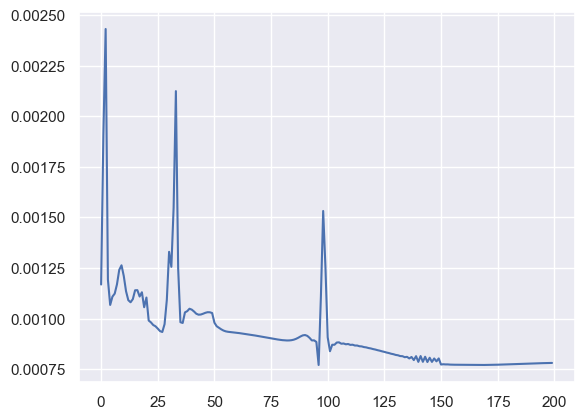

In [13]:
plt.plot(losses)

NMSE: 1.2613242005359864


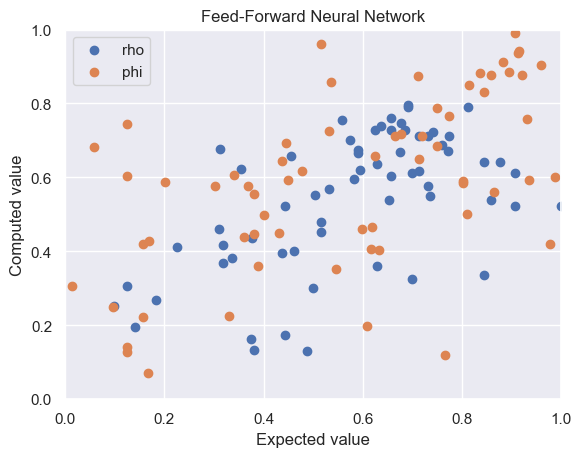

In [14]:
y_test = np.array([(i[0].item(), i[1].item()) for i in Y_test])
y_hat = np.array([model.forward(torch.Tensor(i).unsqueeze(0)).detach().numpy() for i in X_test])
y_hat = np.array([(i[:, 0].item(), i[:, 1].item()) for i in y_hat])
nmse = NMSELoss([pol2cart(i) for i in Y_test], [pol2cart(i) for i in y_hat])
print("NMSE:", nmse)
plt.scatter(y_test[:, 0], y_hat[:, 0])
plt.scatter(y_test[:, 1], y_hat[:, 1])
plt.legend(["rho", "phi"])
plt.xlabel("Expected value")
plt.ylabel("Computed value")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Feed-Forward Neural Network")
plt.savefig("../Results/FFN_PC.jpg", dpi=250)

In [15]:
with open("../Results/results.csv", 'a') as f:
    f.write("FNN_PC" + "," + str(nmse)[:7] + "," + str(t)[:7] + "," + str(nmse*t)[:7] + "\n")